In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls
#!rm /content/gdrive/MyDrive/*.txt
#!unzip /content/gdrive/MyDrive/Data/archive 

gdrive	sample_data


In [ ]:
from google.colab import files 
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thinhphan97","key":"68feadf3a351c2b1a52995eddca2ea32"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!nvidia-smi

Fri May 21 08:36:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!kaggle datasets download -d awsaf49/vinbigdata-512-image-dataset

100% 2.30G/2.30G [00:30<00:00, 12.8MB/s]
100% 2.30G/2.30G [00:30<00:00, 79.8MB/s]


In [ ]:
!unzip vinbigdata-512-image-dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: vinbigdata/train/a9f2816d377349f221a96f46c728d36e.png  
  inflating: vinbigdata/train/a9f32aee073a0ee7ea94e959ab63885c.png  
  inflating: vinbigdata/train/a9f467688d104d27583ea3b3154b1f30.png  
  inflating: vinbigdata/train/a9f4c9a4971b3877981e09d4a2ac7fc0.png  
  inflating: vinbigdata/train/a9f60e50925ece0b5c00b6bbd9f0825c.png  
  inflating: vinbigdata/train/aa0202259a3cba71d0e72468e2d9c3e2.png  
  inflating: vinbigdata/train/aa08370eb6114a474adfd0accb6a7238.png  
  inflating: vinbigdata/train/aa0a24df022cd97cc1dff4f7ea2131cc.png  
  inflating: vinbigdata/train/aa0b79c06462e126d97b73a15187c9c4.png  
  inflating: vinbigdata/train/aa1203b1ecab0cddec19f07eb68d4dee.png  
  inflating: vinbigdata/train/aa12ea6652b3b8bea37df74e4e127e8f.png  
  inflating: vinbigdata/train/aa161d1deb918990c3e196501a714994.png  
  inflating: vinbigdata/train/aa1758ce7d9f3cb0bbba72d163ffc69a.png  
  inflating: vinbigdata/train/aa17d5312a0fb4a2

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("/content/vinbigdata/train.csv")
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [ ]:
is_normal_df = train_df.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df

,image_id,num_normal_annotations
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,0
...,...,...
14995,ffe6f9fe648a7ec29a50feb92d6c15a4,0
14996,ffea246f04196af602c7dc123e5e48fc,3
14997,ffeffc54594debf3716d6fcd2402a99f,0
14998,fff0f82159f9083f3dd1f8967fc54f6a,3


In [ ]:
def change(x):
    if (x==3):
        x=1
    return x
is_normal_df['target'] = is_normal_df['num_normal_annotations'].apply(lambda x: change(x))
df = is_normal_df[["image_id","target"]]
df.head()

,image_id,target
0,000434271f63a053c4128a0ba6352c7f,1
1,00053190460d56c53cc3e57321387478,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,1
4,0007d316f756b3fa0baea2ff514ce945,0


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 4, random_state = 42,shuffle = True)
folds = df.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.target)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)

In [ ]:
import os
folds.image_id=folds.image_id+".png"
img_path = "/content/vinbigdata/train"
df_paths = [os.path.join(img_path,x) for x in folds.image_id]
folds['path'] = df_paths
folds.head()

,image_id,target,fold,path
0,000434271f63a053c4128a0ba6352c7f.png,1,0,/content/vinbigdata/train/000434271f63a053c412...
1,00053190460d56c53cc3e57321387478.png,1,2,/content/vinbigdata/train/00053190460d56c53cc3...
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,/content/vinbigdata/train/0005e8e3701dfb1dd93d...
3,0006e0a85696f6bb578e84fafa9a5607.png,1,2,/content/vinbigdata/train/0006e0a85696f6bb578e...
4,0007d316f756b3fa0baea2ff514ce945.png,0,1,/content/vinbigdata/train/0007d316f756b3fa0bae...


In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 24.2MB/s 
     |████████████████████████████████| 952kB 40.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=22c9116acfaa86c3e9edf9b4d11e02acc1fce49ed932a7e19bb4955a49a31db4
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_aug = A.Compose(
    [  

        A.Resize(300,300,p=1.0),
        A.CLAHE(clip_limit=4.0, p=0.85),

     A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0)
    ]
)
val_aug = A.Compose(
    [
         A.Resize(300,300,p=1.0),
        A.HorizontalFlip(p=0.5),
         A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0),
    ]
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
import cv2
import numpy as np

In [ ]:
class Xray(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img_src = self.df.loc[idx,'path']
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        target = self.df.loc[idx,'target']
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        
        return image,torch.tensor(target) 

In [ ]:
data = Xray(folds,augs = train_aug)
print(len(data))
load = DataLoader(data,batch_size = 1)
img,target = next(iter(load))

15000


In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


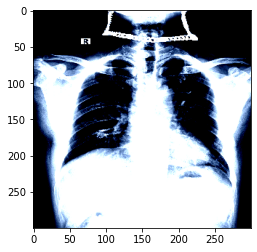

In [ ]:
plt.imshow(img.squeeze(0).permute(1,2,0))

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 6693, done.
remote: Counting objects: 100% (870/870), done.
remote: Compressing objects: 100% (402/402), done.
remote: Total 6693 (delta 569), reused 677 (delta 461), pack-reused 5823
Receiving objects: 100% (6693/6693), 17.29 MiB | 30.90 MiB/s, done.
Resolving deltas: 100% (4838/4838), done.


In [ ]:
timm_path = "/content/pytorch-image-models"
import sys
sys.path.append(timm_path)
import timm
from tqdm.notebook import tqdm
import sklearn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.8MB 29.1MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 174kB 48.7MB/s 
     |████████████████████████████████| 133kB 52.8MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=7d454b0ebda56a16576fe8dd85df3967338ebbaccab6d14e65b382cef23d48d8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=2c6699d67be30c6a433ccdc20f9509e98a84018053984e93b34b9ecbdea88d13
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs):
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        output = model(image)
        batch_size = labels.size(0)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'train')
              
        except ValueError:
            pass       
    return losses.avg, scores.avg

In [ ]:
def val_one_epoch(loader,model,optimizer,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'valid')
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        except ValueError:
            pass
     
    return losses.avg, scores.avg

In [ ]:
def fit(model,fold_n, model_name, training_batch_size=32,validation_batch_size=64):
    
    train_data=folds[folds.fold != fold_n]
    val_data=folds[folds.fold == fold_n]
    train_data= Xray(train_data.reset_index(drop=True),augs = train_aug)
    val_data= Xray(val_data.reset_index(drop=True),augs = val_aug)
    
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=0,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=0,
                        batch_size=validation_batch_size)
    model = model
    model.to(device)
    criterion=nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 3,verbose = True)
    epochs= 10
    
    best_auc = 0
    
    loop = range(epochs)
    for e in loop:
        
        train_loss,train_auc = train_one_epoch(train_loader,model,optimizer,criterion,e,epochs)
         #scheduling step if given
    
        #scheduler.step()
        
        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_auc {train_auc}' )
        
        val_loss,val_auc = val_one_epoch(valid_loader,model,optimizer,criterion)
        
        scheduler.step(val_loss)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_auc {val_auc}')
        
        
        
        
        if (val_auc>best_auc):
            best_auc =val_auc
            print(f'saving model for {best_auc}')
            torch.save(model.state_dict(),OUTPUT_DIR+ f'Fold {fold_n} model {model_name} with val_acc {best_auc}.pth') 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
OUTPUT_DIR = '/content/gdrive/MyDrive/Model/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
supported_models = timm.list_models()
print(f"{len(supported_models)} models are supported in timm.")
for i in range(0,len(supported_models),5):
  print(supported_models[i:(i+5)])

550 models are supported in timm.
['adv_inception_v3', 'botnet26t_256', 'botnet50ts_256', 'cait_m36_384', 'cait_m48_448']
['cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224']
['cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small']
['coat_lite_tiny', 'coat_mini', 'coat_tiny', 'cspdarknet53', 'cspdarknet53_iabn']
['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'cspresnext50', 'cspresnext50_iabn']
['darknet53', 'densenet121', 'densenet121d', 'densenet161', 'densenet169']
['densenet201', 'densenet264', 'densenet264d_iabn', 'densenetblur121d', 'dla34']
['dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next']
['dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2']
['dla169', 'dm_nfnet_f0', 'dm_nfnet_f1', 'dm_nfnet_f2', 'dm_nfnet_f3']
['dm_nfnet_f4', 'dm_nfnet_f5', 'dm_nfnet_f6', 'dpn68', 'dpn68b']
['dpn92', 'dpn98', 'dpn107', 'dpn131', 'eca_nfnet_l0']
['eca_nfnet_l1', 'eca_vovnet39b', 'ecaresnet26t', 'ecaresnet50d'

In [ ]:
model = timm.create_model('efficientnet_b0',pretrained= False, num_classes=1)


In [ ]:
fit(model,0,"efficientnet_b0")


For epoch 1/10
average train_loss 0.7735592562410567
average train_auc 0.7971877035301507



avarage val_loss 1.5169055140813192
avarage val_auc 0.7549760546078219
saving model for 0.7549760546078219



For epoch 2/10
average train_loss 0.3048848820871777
average train_auc 0.9408266222540558



avarage val_loss 0.38126341330210367
avarage val_auc 0.8932344549302509
saving model for 0.8932344549302509



For epoch 3/10
average train_loss 0.24432889818085565
average train_auc 0.9659771934161995



avarage val_loss 0.36470412611961367
avarage val_auc 0.8958106513215495
saving model for 0.8958106513215495



For epoch 4/10
average train_loss 0.1984569864577717
average train_auc 0.9780139741956143



avarage val_loss 0.5739835147857666
avarage val_auc 0.926781404332184
saving model for 0.926781404332184



For epoch 5/10
average train_loss 0.17421612099011738
average train_auc 0.9820541815826334



avarage val_loss 0.7711430047988892
avarage val_auc 0.8698663613648758



For epoch 6/10
average train_loss 0.16723962127367656
average train_auc 0.9841916751310091



avarage val_loss 0.6388251136461893
avarage val_auc 0.9172457332934228



For epoch 7/10
average train_loss 0.13397489741245905
average train_auc 0.9906284017517979



Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
avarage val_loss 1.0422646384557088
avarage val_auc 0.8927112891948266



For epoch 8/10
average train_loss 0.06318218116429117
average train_auc 0.9975382047752913



avarage val_loss 0.3855228139877319
avarage val_auc 0.9276045402301917
saving model for 0.9276045402301917



For epoch 9/10
average train_loss 0.03272343451165491
average train_auc 0.9995832511598087



avarage val_loss 0.4618761381149292
avarage val_auc 0.9325840009935157
saving model for 0.9325840009935157



For epoch 10/10
average train_loss 0.022043744346768493
average train_auc 0.999882388623722



avarage val_loss 0.5628892862002055
avarage val_auc 0.9297638636367367


In [ ]:
torch.cuda.is_initialized()

True

In [ ]:
!nvidia-smi


Fri May 21 09:46:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |  14980MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model=timm.create_model('efficientnetv2_s', pretrained=False, num_classes=1) # set pretrained=True to use the pretrained weights

In [ ]:
fit(model,0,'efficientnetv2_s')


For epoch 1/10
average train_loss 0.6350774184544882
average train_auc 0.8278981665825351



avarage val_loss 1.394194016901652
avarage val_auc 0.7348810305706376
saving model for 0.7348810305706376



For epoch 2/10
average train_loss 0.34938543967141045
average train_auc 0.9156100547351526



avarage val_loss 1.3596903004010519
avarage val_auc 0.7818561063772677
saving model for 0.7818561063772677



For epoch 3/10
average train_loss 0.288468625164032
average train_auc 0.9447408935414889



avarage val_loss 7.079471790440877
avarage val_auc 0.7296335426549582



For epoch 4/10
average train_loss 0.24796443872451782
average train_auc 0.9595573554772531



avarage val_loss 0.550547473971049
avarage val_auc 0.8511257006261507
saving model for 0.8511257006261507



For epoch 5/10
average train_loss 0.22702715216610167
average train_auc 0.9671378477845438



avarage val_loss 2.1384856243133545
avarage val_auc 0.8483998642399493



For epoch 6/10
average train_loss 0.20795570401350658
average train_auc 0.9712843977244768



avarage val_loss 0.5229482192993165
avarage val_auc 0.8467118874035979



For epoch 7/10
average train_loss 0.1959758439593845
average train_auc 0.9768051640149714



avarage val_loss 2.8150124987284344
avarage val_auc 0.719687736324473



For epoch 8/10
average train_loss 0.18089962142308552
average train_auc 0.9792933749070805



avarage val_loss 0.8839295642217
avarage val_auc 0.8351012222789878



For epoch 9/10
average train_loss 0.16903954781426322
average train_auc 0.9818723322759951



avarage val_loss 2.3927200550079344
avarage val_auc 0.7738024603996504



For epoch 10/10
average train_loss 0.17217785703341165
average train_auc 0.983041206841057



Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
avarage val_loss 2.4337998662312827
avarage val_auc 0.6225356895381288


In [ ]:
!pip install numba 


In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
!nvidia-smi

Fri May 21 09:48:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model2=timm.create_model('efficientnet_b8', pretrained=False) # set pretrained=True to use the pretrained weights
num_features = model2.classifier.in_features
model2.classifier = nn.Linear(num_features, 1)
model2

EfficientNet(
  (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
        (bn1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseS

In [ ]:
fit(model2,0,'efficientnet_b8')

RuntimeError: ignored

In [ ]:
model3=timm.create_model('tf_efficientnet_b3_ns', pretrained=False) # set pretrained=True to use the pretrained weights
num_features = model3.classifier.in_features
model3.classifier = nn.Linear(num_features, 1)
model3

In [ ]:
fit(model3,3,'tf_efficientnet_b3_ns')

In [ ]:
!git clone https://github.com/d-li14/efficientnetv2.pytorch.git

In [ ]:
import effnetv2

model4 = effnetv2.effnetv2_s(num_classes=1)
model4

In [ ]:
fit(model= model4, fold_n=0, model_name="effnetv2_s")

In [ ]:
model5 = effnetv2.effnetv2_m(num_classes=1)
model5

In [ ]:
fit(model= model5, fold_n=0, model_name="effnetv2_m")